# KMeans Clustering

The k-means algorithm is a popular clustering algorithm that aims to partition all observations into k clusters. Each cluster is identified by its centroid. Each observation belongs to one cluster and its membership is determined by the least distance to the centroid of a cluster, compared with the distance to the centroids of all the other clusters. During clustering we want our model to create clusters such that cluster cohesion is low and cluster separation is high. 

### Evaluation Metrics:

**Cluster Cohesion** is measured by ‘within-cluster sum of squares’ (**SSE**).

$$Cluster \, Cohesion = \Sigma_{x \in C_{i}}dist(c_{i}, x)^2$$

**Cluster Separation** is measured by how well a cluster is separated from other clusters (**SSB**).

$$Cluster \, Separation = \Sigma_{i=1}^{k}m_{i}dist(c_{i}, c)^2$$
Where mi is the size of the cluster.


In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans, Birch
from sklearn.cluster import KMeans as KMeansPack

%matplotlib inline

def printmd(string):
    display(Markdown(string))

## 1. Implementation for kNN

We take data and k as parameters to the function, where k is the number of centroids. The coordinates of the centroids is an optional parameter. We use this parameter to test various centroid initialization techniques.

We then follow the steps below:

* **Step 1:** If centroids are not passed to the function using the optional parameter, we randomly initialize k centroids in the same dimensional space as records in the data. Each centroid is associated with a cluster class (in our case 1, 2, … K classes).

* **Step 2:** Assign each record in the data a cluster class, which is the class of the centroid nearest to it. We do so by comparing the distance of each observation from all the centroids and choosing the centroid with the least euclidean distance from the observation.

* **Step 3:** After all the observations have been assigned a cluster class, we update each centroid to be the mean of all the observations in its cluster.

* **Step 4:** We repeat Step 2 and Step 3 until the centroids do not change.                          

Additionally we output the coordinates of the centroids, number of runs of step 2 and 3 and the cluster member of all the points.

**We try three different methods for initializing the centroids.**

* **Random Initialization**: We initialize the centroids by randomly choosing values, such that each dimension’s value lies between the minimum and maximum values of that corresponding dimension in the dataset. This method does not ensure that every cluster class will have at least one record.


* **Random Sampling**: We initialize the centroids by randomly choosing k samples from the dataset. This method ensures that each cluster class will at least have one record.


* **Sampling with Conditions**: We start by choosing k random samples from the dataset as centroids. We then proceed to check if other observations from the dataset are better candidates as initial centroids.
    
    For each observation ‘j’ in the dataset we do the following:
    
    **Condition 1:** If the distance between observation j and its closest centroid (c1) is greater than the distance between the two closest centroids (c2 & c3), j substitutes either c2 or c3 as an initial centroid depending on which one it is closer to.
    
    **Condition 2:** If the distance between observation j and its second closest centroid (say c4) is greater than the distance between the centroid closest to j (c1) and centriod closest to c4 (c5), then j substitutes the centroid closest to it, c1, as one of the initial centroids.

    If condition 1 is not satisfied then condition 2 is checked. If both fail, the jth observation does not become an initial centroid. This approach diminishes the chance of getting trapped into a "local optimum", and speeds up the process of convergence.


In [2]:
# Functions of KMeans

def initializeCentroids(k, d, low = 0, high = 1):
    return np.random.uniform(low, high, size = (k,d))

def setClusters(data, centroids, euclidean):
    return np.apply_along_axis(euclidean, 1, data, centroids)


def euclideanRank(centroids, point, nsmall = 0):
    return rankCluster(np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = 1)), nsmall)

def euclideanDist(centroids, point):
    return np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = len(centroids.shape)-1)) # Hack

def rankCluster(y, n):
    return np.argpartition(y, n)[n]+1

def updateCentroids(data, clusters, centroids):
    for i in range(centroids.shape[0]):
        if i+1 in clusters:
            centroids[i, ] = data[np.where(clusters == i+1), ].mean(axis = 1)
    return centroids

def nSmallestDistPoints(points, n):
    l = []
    for i in range(points.shape[0]):
        l = np.append(l, euclideanDist(points, points[i, ]))

    n *= 2
    ind = np.argpartition(l, points.shape[0] + n)[points.shape[0] + n]
    r = int(np.floor(ind / points.shape[0]))
    c = int(np.floor(ind % points.shape[0]))
    return r, c, l[ind]

def reallyreallyInitializeCentroids(data, k):
    centroids = data[np.random.randint(0, data.shape[0], k), ]
    replacement_counter = 0
    for i in range(data.shape[0]):
        case = data[i, ]
        closest1, closest2, dist = nSmallestDistPoints(centroids, 1)
        if np.min(euclideanDist(centroids, case)) > dist:
            if euclideanDist(centroids[closest1, ], case) > euclideanDist(centroids[closest2, ], case):
                centroids[closest2, ] = case
            else:
                centroids[closest1, ] = case
            replacement_counter += 1
        else:
            second_closest_case = np.argpartition(euclideanDist(centroids, case), 1)[1]
            first_closest_case = np.argpartition(euclideanDist(centroids, case), 0)[0]
            closest_to_second_closest_case = np.argpartition(euclideanDist(centroids, centroids[second_closest_case, ]), 1)[1]
            #closest1, closest2, dist = nSmallestDistPoints(centroids, 2)

            if np.partition(euclideanDist(centroids, case), 1)[1] > euclideanDist(centroids[second_closest_case, ], centroids[closest_to_second_closest_case, ]):
                centroids[first_closest_case, ] = case
                replacement_counter += 1
    #print('Centroids replaced %d time(s).' % (replacement_counter))
    return centroids

def KMeansFormal(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    
    return pd.DataFrame({'RowID' : [i for i in range(len(clusters))], 'Cluster' : clusters})

def KMeans(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    return centroids, run_counter, clusters

def calculateMeasures(data, clusters, centroids):
    SSE, SSB = 0, 0
    SSE_cluster = []
    for i in range(centroids.shape[0]):
        SSB += euclideanDist(np.mean(data, axis = 0), centroids[i]) * len(np.where(clusters == i+1)[0])
        cluster_filter = np.where(clusters == i+1)
        if len(cluster_filter[0]) == 0:
            temp = 0
        else:
            temp = np.sum(np.apply_along_axis(euclideanDist, 1, data[cluster_filter], centroids[i]))
        SSE += temp
        SSE_cluster.append(temp)
        
    return SSE, SSB, SSE_cluster

def softmax(x):

    x = x - np.max(x, axis = x.ndim - 1, keepdims=True)
    x = np.exp(x) / np.sum(np.exp(x), axis = x.ndim - 1, keepdims = True)
    
    return x


## 2. Dataset 1 : TwoDimHard

The dataset has 400 records and 3 features. For this dataset the feature ‘cluster’ represents the true cluster membership of the record.

**Features**
* X.1
* X.2

**True Class Membership**
* Cluster 


In [5]:
TwoDim = pd.read_csv('TwoDimHard.csv')

# Convert to a numpy array
Two = np.array(TwoDim[['X.1','X.2']])

printmd('**Data Snapshot**')
display(TwoDim.head(10))

**Data Snapshot**

,ID,X.1,X.2,cluster
0,1,0.276724,0.793762,1
1,2,0.346407,0.797695,1
2,3,0.296033,0.845381,1
3,4,0.333519,0.774505,1
4,5,0.347625,0.737573,1
5,6,0.443881,0.760030,1
6,7,0.358073,0.736421,1
7,8,0.305019,0.722984,1
8,9,0.235237,0.764224,1
9,10,0.304484,0.720066,1


In [7]:
printmd('**Data Types**')
display(TwoDim.info())

**Data Types**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
ID         400 non-null int64
X.1        400 non-null float64
X.2        400 non-null float64
cluster    400 non-null int64
dtypes: float64(2), int64(2)
memory usage: 12.6 KB


None

**Box Plots**

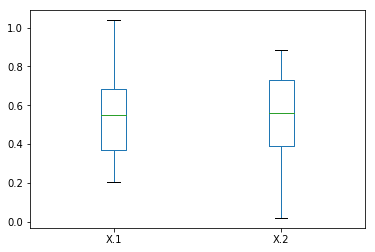

In [11]:
TwoDim.drop(columns = ['ID', 'cluster']).plot(kind = 'box')
printmd('**Box Plots**')

In [13]:
printmd('**Sample Output**')
KMeansFormal(4, Two).head()

**Sample Output**

,Cluster,RowID
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4


### 2.1. True Cluster Membership

SSB : 95.400839
SSE : 39.600296
Cluster-wise SSE:
Cluster 1: 4.500000
Cluster 2: 8.410000
Cluster 3: 13.730000
Cluster 4: 12.950000


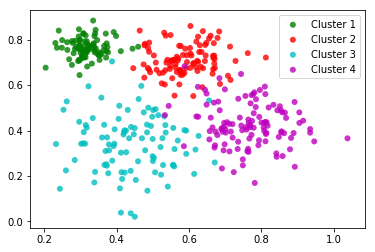

In [14]:
groups = TwoDim.groupby('cluster')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.scatter(group['X.1'], group['X.2'],alpha=0.8, c=colors[name], edgecolors='none', label='Cluster '+str(name))
ax.legend()


#printmd('## True Cluster Membership')
SSE, SSB, SSE_cluster = calculateMeasures(Two, TwoDim.cluster.values, updateCentroids(Two, TwoDim.cluster.values, np.zeros((4,Two.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
plt.show()

### 2.2. Nearest Neighbour with K = 4

In [15]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(4, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)

printmd('**Evaluation performance of random centroid initialization**')
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


**Evaluation performance of random centroid initialization**

Mean SSE : 42.236043 & Mean SSB : 94.460111


37.97 | 96.34    68
50.82 | 91.24     6
50.8 | 91.15      5
50.78 | 91.12     5
50.79 | 90.84     4
50.77 | 91.06     4
53.65 | 84.46     2
51.14 | 91.32     2
53.88 | 90.64     2
53.74 | 84.41     1
51.41 | 91.47     1
dtype: int64

**Class membership when K = 4**

SSB : 96.336777
SSE : 37.971170
Cluster-wise SSE:
Cluster 1: 5.530000
Cluster 2: 11.770000
Cluster 3: 9.480000
Cluster 4: 11.190000

Iteration till convergence : 8


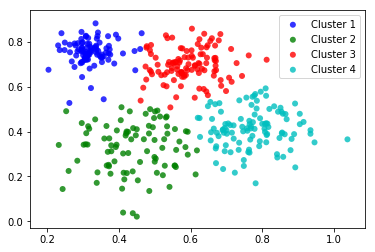

In [20]:
centroids, iterations, clusters = KMeans(4, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('**Class membership when K = 4**')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()

In [25]:
new_clusters = []
for i in clusters:
    if i == 1:
        new_clusters.append(1)
    elif i == 3:
        new_clusters.append(2)
    elif i == 2:
        new_clusters.append(3)
    elif i == 4:
        new_clusters.append(4)

printmd('**Cross Tab Comparison between True Clusters and Clusters with K = 4**')
display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))



**Cross Tab Comparison between True Clusters and Clusters with K = 4**

True Clusters,1,2,3,4
Assigned Cluster,,,,
1,89,2,4,0
2,0,98,2,8
3,0,0,88,2
4,0,0,3,104


We ran K means using each of our centroid initialization techniques for 100 runs. We found that on average our random initialization technique outperformed other methods in both having lower cluster cohesion and higher cluster separation. We feel that this method of initialization works better due to the nature of the data, that is, the range and spread of the two features are similar.

### 2.3. Nearest Neighbour with K = 3

In [27]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(3, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
printmd('**Evaluation performance of random centroid initialization**')
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


**Evaluation performance of random centroid initialization**

Mean SSE : 54.005047 & Mean SSB : 88.670474


53.9 | 90.7      42
53.88 | 90.64    27
53.65 | 84.46    17
53.78 | 84.39     4
53.74 | 84.41     4
53.92 | 84.42     3
54.24 | 84.41     2
69.52 | 77.27     1
dtype: int64

**Class membership when K = 3**

SSB : 90.702906
SSE : 53.901526
Cluster-wise SSE:
Cluster 1: 12.220000
Cluster 2: 27.250000
Cluster 3: 14.430000

Iteration till convergence : 9


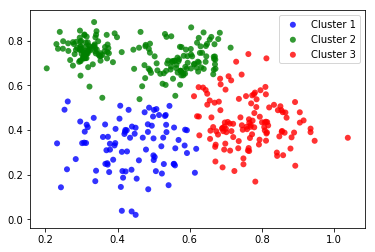

In [34]:
centroids, iterations, clusters = KMeans(3, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('**Class membership when K = 3**')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()


In [36]:
new_clusters = []
for i in clusters:
    if i == 2:
        new_clusters.append(1)
    elif i == 2:
        new_clusters.append(2)
    elif i == 1:
        new_clusters.append(3)
    elif i == 3:
        new_clusters.append(4)

printmd('**Cross Tab Comparison between True Clusters and Clusters with K = 3**')
display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))
printmd('*Note: Cluster numbers have been changed from the plot. We’ve skipped Cluster 2 (as Cluster 1 for K = 3, covers Cluster 1 & 2 for K=4) to get a better like-for-like comparison.')

**Cross Tab Comparison between True Clusters and Clusters with K = 3**

True Clusters,1,2,3,4
Assigned Cluster,,,,
1,89,92,5,1
3,0,0,89,3
4,0,8,3,110


*Note: Cluster numbers have been changed from the plot. We’ve skipped Cluster 2 (as Cluster 1 for K = 3, covers Cluster 1 & 2 for K=4) to get a better like-for-like comparison.

In [37]:
# # Sampling Centroids
# SSE, SSB = [], []
# for i in range(100):
#     cent = reallyreallyInitializeCentroids(Two, 4)
#     centroids, iterations, clusters = KMeans(4, Two, cent)
#     t1, t2, _ = calculateMeasures(Two, clusters, centroids)
#     SSE.append(t1)
#     SSB.append(t2)
    
# print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

In [38]:
# cent = reallyreallyInitializeCentroids(Two, 4)
# centroids, iterations, clusters = KMeans(4, Two, cent)
# #(TwoDim.cluster == clusters).value_counts()

# labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# for data, color, group in zip(np.unique(clusters), colors, labels):
#     x = Two[np.where(clusters == data)]
#     ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
# plt.legend(loc=1)


# printmd('## Clustering Plot')
# SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
# print('SSB : %f' % (SSB))
# print('SSE : %f' % (SSE))
# print('Cluster-wise SSE:')
# for i,x in enumerate(SSE_cluster):
#     print('Cluster %d: %f' %(i+1, round(x,2)))


# plt.show()

### 2.4. Performance versus K value

Increasing the number of clusters changes the results for the better as we can see from figure below. For low values of K, more general clusters are formed. For higher values, more granular clusters are formed. Therefore, while increasing the number of clusters from 3 to 4 improves the model, we have to carefully evaluate the model before increasing the K value.

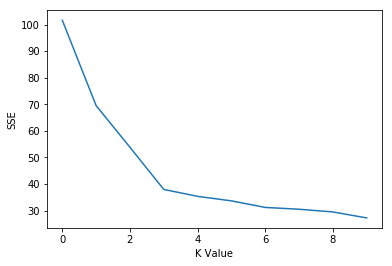

In [42]:
SSE_per_k = []
for j in range(1,11):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        centroids, iterations, clusters = KMeans(j, Two)
        t1, t2, _ = calculateMeasures(Two, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k.append(np.mean(SSE))
    
#SSE_per_k
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
printmd('Increasing the number of clusters changes the results for the better as we can see from figure below. For low values of K, more general clusters are formed. For higher values, more granular clusters are formed. Therefore, while increasing the number of clusters from 3 to 4 improves the model, we have to carefully evaluate the model before increasing the K value.')

## 3. Dataset 2 : Wine Data Clustering

This is a dataset of 1599 wine samples and their attributes. Following attributes are available in the dataset:

**Features**
* Fixed acidity
* Volatile acidity
* Citric acid
* Residual sugar
* Chlorides
* Free sulfur dioxide
* Total sulphur dioxide
* Density
* pH
* Sulphates
* Alcohol

**True Class Membership**
* Quality  


From prior [analysis](https://github.com/saravrajavelu/WineQualityAnalysis/blob/master/WineAnalysis.ipynb) we know:
    
The following pairs are most highly correlated.
* **Fixed acidity** and **Citric acid**: 0.699
* **Fixed acidity** and **density**: 0.66
* **Free sulphur dioxide** and **total sulphur dioxide**: 0.66

Since we don’t want highly correlated variables to skew the model by counting their influence twice over, we remove three of these attributes.

We choose to remove both citric acid and density as they correlate with fixed acidity. We also remove the feature total sulphur dioxide. We removed this over free sulphur dioxide because total sulphur dioxide is on a larger scale compared to the rest of the features

In [45]:
# Data Load
wine = pd.read_csv('winequality-red.csv', sep = ';')
Wine_Base = np.array(wine.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide']))


scaler = preprocessing.MinMaxScaler()
scaler.fit(Wine_Base)
Wine_Norm = scaler.transform(Wine_Base)
Wine_Softmax = softmax(Wine_Base)

In [47]:
printmd('**True membership counts**')
wine.quality.value_counts()


**True membership counts**

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

### 3.1. Non normalized data

**Box Plot **

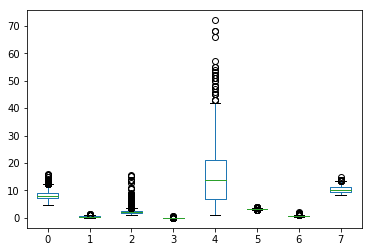

In [48]:
pd.DataFrame(Wine_Base).plot(kind = 'box')
printmd('**Box Plot **')

In [50]:
printmd('**K = 10 with random centroids**')
centroids, iterations, clusters = KMeans(10, Wine_Base)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
#for i,x in enumerate(SSE_cluster):
    #print('Cluster %d: %f' %(i+1, round(x,2)))

**K = 10 with random centroids**

Number of iterations : 2
8    1599
dtype: int64


SSB : 0.000000
SSE : 13933.522005
Cluster-wise SSE:


In [51]:
printmd('**K = 10 with conditioned sampling**')
k = 10
cent = reallyreallyInitializeCentroids(Wine_Base, k)
centroids, iterations, clusters = KMeans(k, Wine_Base, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
#for i,x in enumerate(SSE_cluster):
    #print('Cluster %d: %f' %(i+1, round(x,2)))

**K = 10 with conditioned sampling**

Number of iterations : 24
8     522
4     396
2     277
6     196
1     110
3      65
9      19
5       6
10      4
7       4
dtype: int64


SSB : 13143.136139
SSE : 4355.418785
Cluster-wise SSE:


### Comparision of centroid initialization techniques

### Part 1. Sampling with Conditions

In [15]:
SSE_per_k_Base = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Base, j)
        centroids, iterations, clusters = KMeans(j, Wine_Base, cent)
        t1, t2, _ = calculateMeasures(Wine_Base, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Base.append(np.mean(SSE))

Text(0,0.5,'SSE')

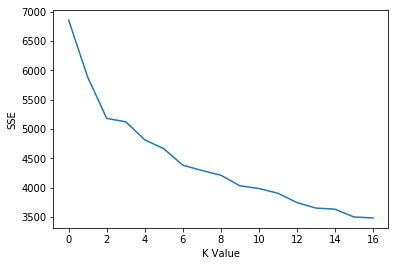

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Base, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

### Part 2. Random Sampling 

Text(0,0.5,'SSE')

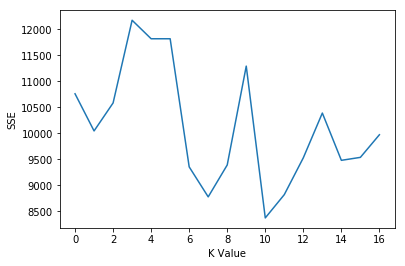

In [17]:
SSE_per_k_Base_Rand = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        centroids, iterations, clusters = KMeans(j, Wine_Base)
        t1, t2, _ = calculateMeasures(Wine_Base, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Base_Rand.append(np.mean(SSE))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Base_Rand, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

### Comparison graph

Text(0,0.5,'SSE')

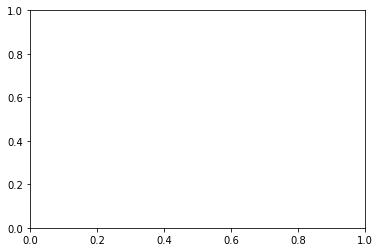

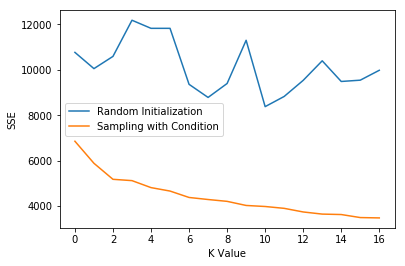

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.DataFrame({'Sampling with Condition': SSE_per_k_Base, 'Random Initialization' : SSE_per_k_Base_Rand}).plot()
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

### 3.2. Min-Max Normalizaed

**Box Plot**

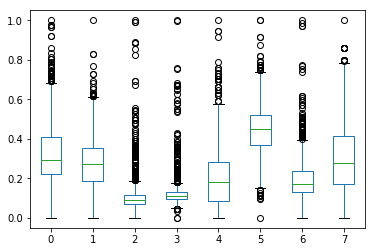

In [54]:
pd.DataFrame(Wine_Norm).plot(kind = 'box')
printmd('**Box Plot**')

In [57]:
printmd('**K = 10, random sampling**')
centroids, iterations, clusters = KMeans(10, Wine_Norm)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())


print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

**K = 10, random sampling**

Number of iterations : 45
10    559
6     294
2     249
9     233
5     200
1      35
8      29
dtype: int64


SSB : 384.698147
SSE : 366.701628
Cluster-wise SSE:
Cluster 1: 14.230000
Cluster 2: 57.600000
Cluster 3: 0.000000
Cluster 4: 0.000000
Cluster 5: 50.750000
Cluster 6: 71.140000
Cluster 7: 0.000000
Cluster 8: 9.330000
Cluster 9: 55.260000
Cluster 10: 108.400000


In [58]:
printmd('**K = 10, conditioned sampling**')
k = 10
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

**K = 10, conditioned sampling**

Number of iterations : 14
3     539
6     269
1     216
2     186
5     184
10    125
4      33
8      23
7      23
9       1
dtype: int64


SSB : 395.051710
SSE : 355.552636
Cluster-wise SSE:
Cluster 1: 46.990000
Cluster 2: 41.300000
Cluster 3: 102.290000
Cluster 4: 13.450000
Cluster 5: 47.110000
Cluster 6: 63.550000
Cluster 7: 5.040000
Cluster 8: 7.270000
Cluster 9: 0.000000
Cluster 10: 28.560000


In [22]:
SSE_per_k_Norm = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Norm, j)
        centroids, iterations, clusters = KMeans(j, Wine_Norm, cent)
        t1, t2, _ = calculateMeasures(Wine_Norm, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Norm.append(np.mean(SSE))

Text(0,0.5,'SSE')

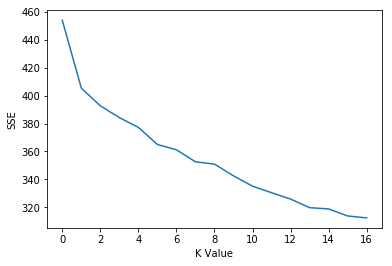

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Norm, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

### 3.3. Softmax Normalizaed

**Box Plot**

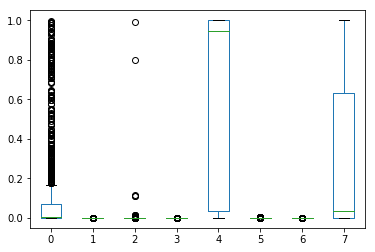

In [59]:
printmd('**Box Plot**')
pd.DataFrame(Wine_Softmax).plot(kind = 'box')

In [60]:
printmd('**K = 10, random sampling**')
centroids, iterations, clusters = KMeans(10, Wine_Softmax)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

**K = 10, random sampling**

Number of iterations : 8
4    971
9    626
7      2
dtype: int64


SSB : 849.269831
SSE : 300.820271
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 0.000000
Cluster 4: 75.780000
Cluster 5: 0.000000
Cluster 6: 0.000000
Cluster 7: 0.270000
Cluster 8: 0.000000
Cluster 9: 224.770000
Cluster 10: 0.000000


In [61]:
printmd('**K = 10, conditioned sampling**')
k = 10
cent = reallyreallyInitializeCentroids(Wine_Softmax, k)
centroids, iterations, clusters = KMeans(k, Wine_Softmax, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

**K = 10, conditioned sampling**

Number of iterations : 7
9     849
6     282
3     108
4      87
7      73
8      70
1      70
2      42
5      16
10      2
dtype: int64


SSB : 909.114834
SSE : 86.313315
Cluster-wise SSE:
Cluster 1: 7.140000
Cluster 2: 4.510000
Cluster 3: 11.610000
Cluster 4: 7.420000
Cluster 5: 2.920000
Cluster 6: 21.340000
Cluster 7: 9.320000
Cluster 8: 7.490000
Cluster 9: 14.310000
Cluster 10: 0.270000


In [27]:
SSE_per_k_Soft = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Softmax, j)
        centroids, iterations, clusters = KMeans(j, Wine_Softmax, cent)
        t1, t2, _ = calculateMeasures(Wine_Softmax, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Soft.append(np.mean(SSE))

Text(0,0.5,'SSE')

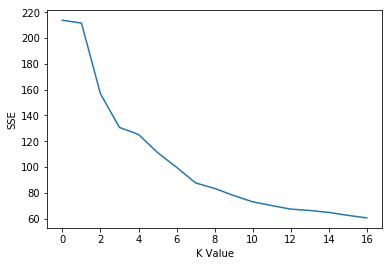

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Soft, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

In [62]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# pd.DataFrame({'Non Normalized Data' : SSE_per_k_Base, 'Min-Max Normalized Data': SSE_per_k_Norm, 'Softmax Normalized Data' : SSE_per_k_Soft}).plot()
# ax.set_xlabel('K Value')
# ax.set_ylabel('SSE')

In [63]:
# %matplotlib notebook
# fig = plt.figure()
# ax = pd.DataFrame({'Min-Max Normalized Data': SSE_per_k_Norm, 'Softmax Normalized Data' : SSE_per_k_Soft}).plot()
# ax.set_xlabel('K Value')
# ax.set_ylabel('SSE')
# fig.show()

### For each of the 3 different forms of our dataset, we run the K-Means algorithm across different values of K and compare the results.

<IPython.core.display.Javascript object>


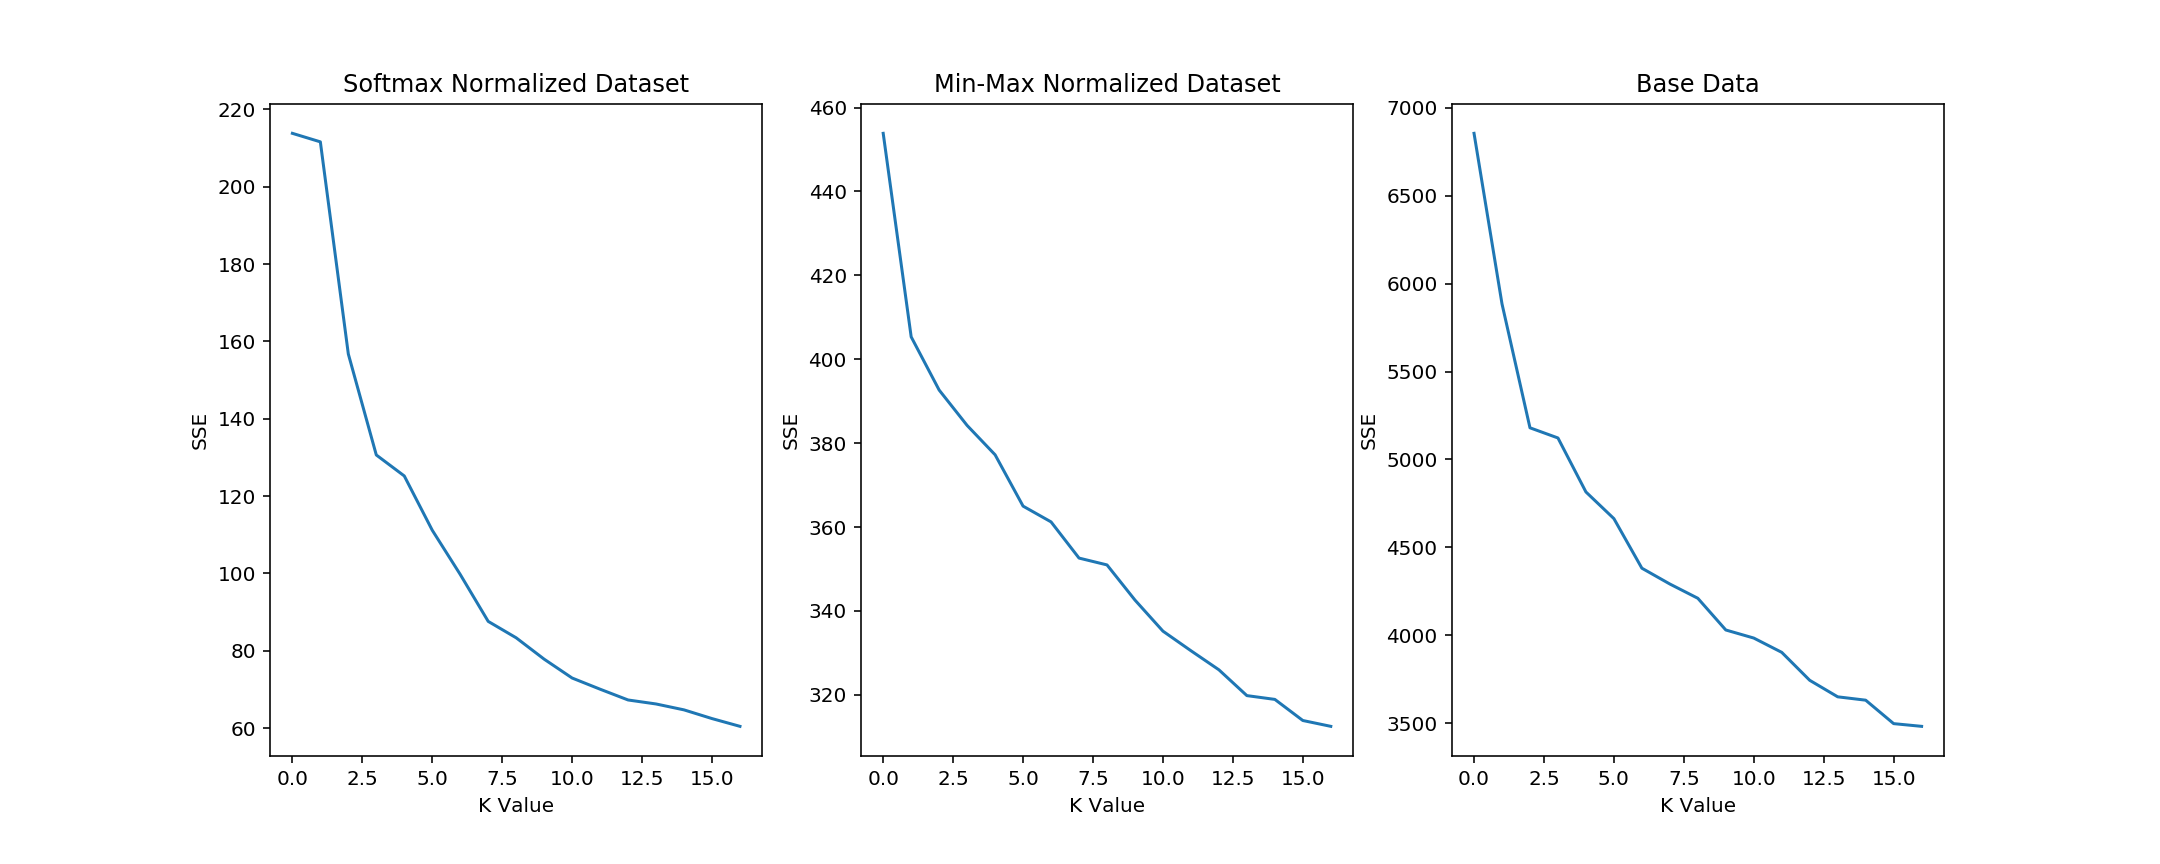

Text(0,0.5,'SSE')

In [34]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))

ax = pd.Series(SSE_per_k_Base, name = 'SSE').plot(kind = 'line', ax =  axs[2], title =  'Base Data')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
ax = pd.Series(SSE_per_k_Norm, name = 'SSE').plot(kind = 'line', ax =  axs[1], title =  'Min-Max Normalized Dataset')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
ax = pd.Series(SSE_per_k_Soft, name = 'SSE').plot(kind = 'line', ax =  axs[0], title =  'Softmax Normalized Dataset')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

### 3.4 Comparing with quality 

In [65]:
printmd('### Quality as Cluster Membership')
k =10

printmd('### Softmax')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, wine.quality.values, updateCentroids(Wine_Softmax, wine.quality.values, np.zeros((k,Wine_Softmax.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
    
printmd('### Base')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, wine.quality.values, updateCentroids(Wine_Base, wine.quality.values, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
printmd('### Min-Max')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, wine.quality.values, updateCentroids(Wine_Norm, wine.quality.values, np.zeros((k,Wine_Norm.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

### Quality as Cluster Membership

### Softmax

SSB : 117.726085
SSE : 893.488849
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 7.040000
Cluster 4: 32.680000
Cluster 5: 354.530000
Cluster 6: 365.690000
Cluster 7: 121.720000
Cluster 8: 11.830000
Cluster 9: 0.000000
Cluster 10: 0.000000


### Base

SSB : 1752.400006
SSE : 13757.663654
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 79.470000
Cluster 4: 396.970000
Cluster 5: 6143.840000
Cluster 6: 5308.000000
Cluster 7: 1664.830000
Cluster 8: 164.560000
Cluster 9: 0.000000
Cluster 10: 0.000000


### Min-Max

SSB : 144.373660
SSE : 496.197060
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 3.510000
Cluster 4: 17.630000
Cluster 5: 202.140000
Cluster 6: 204.340000
Cluster 7: 62.520000
Cluster 8: 6.060000
Cluster 9: 0.000000
Cluster 10: 0.000000


### 3.5. Exporing trends in clusters

We take k = 6 as our ideal value as:
* In spite of the quality feature of the data ranging from 1-10, only 6 of those values (3, 4, 5, 6, 7 & 8) are represented by the observations. This helps us compare our K-Means with that of the quality feature as true cluster class of wine dataset.
* We do not want to choose a higher value of k, as we want to learn more general cluster trends.


In [56]:
k = 6
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 18
1    603
6    332
4    304
5    296
2     35
3     29
dtype: int64
SSB : 368.044307
SSE : 383.988652
Cluster-wise SSE:
Cluster 1: 124.490000
Cluster 2: 14.230000
Cluster 3: 9.330000
Cluster 4: 74.290000
Cluster 5: 76.620000
Cluster 6: 85.030000


### 3.5.1. Cluster Stats

In [57]:
wine_eda = wine.copy()
wine_eda['cal_qual'] = clusters
wine_eda.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide'], inplace = True)
wine_eda.groupby('cal_qual').mean()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol
cal_qual,,,,,,,,
1,7.626368,0.623914,2.259453,0.085557,11.435323,3.352637,0.596070,9.818905
2,8.171429,0.538143,9.322857,0.103229,35.542857,3.260286,0.648286,9.977143
3,8.327586,0.534828,1.982759,0.341172,16.172414,3.038276,1.320000,9.448276
4,8.007895,0.514523,2.391283,0.081957,30.475329,3.323980,0.656546,10.093969
5,7.211824,0.472196,2.379730,0.071686,13.949324,3.414662,0.666858,11.912556
6,10.866867,0.413358,2.656476,0.086226,10.186747,3.160783,0.707831,10.625502


In [58]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [67]:
# def smaller():
#     Wine_Base = np.array(wine.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide','pH', 'volatile acidity']))
#     print(Wine_Base.shape)
#     scaler1 = preprocessing.MinMaxScaler()
#     scaler1.fit(Wine_Base)
#     Wine_Norm = scaler1.transform(Wine_Base)

#     k = 6
#     cent = reallyreallyInitializeCentroids(Wine_Norm, k)
#     centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
#     print('Number of iterations : %d' % (iterations))
#     print(pd.Series(clusters).value_counts())

#     SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
#     print('SSB : %f' % (SSB))
#     print('SSE : %f' % (SSE))
#     print('Cluster-wise SSE:')
#     for i,x in enumerate(SSE_cluster):
#         print('Cluster %d: %f' %(i+1, round(x,2)))

#     wine_eda = wine.copy()
#     wine_eda['Cluster'] = clusters
#     wine_eda.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide'], inplace = True)
#     display(wine_eda.groupby('Cluster').mean())

# smaller()

![alt text](Images/ClusterAnalysis.png "Title")

In [60]:
# Wine_Base = np.array(wine.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide','pH', 'volatile acidity']))
# Wine_Norm = scaler.transform(Wine_Base)

k = 6
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

wine_eda = wine.copy()
wine_eda['cal_qual'] = clusters
wine_eda.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide'], inplace = True)
display(wine_eda.groupby('cal_qual').mean())

Number of iterations : 22
5    525
1    290
3    281
2    259
4    209
6     35
dtype: int64
SSB : 371.667463
SSE : 386.166297
Cluster-wise SSE:
Cluster 1: 70.280000
Cluster 2: 65.070000
Cluster 3: 72.400000
Cluster 4: 58.970000
Cluster 5: 105.210000
Cluster 6: 14.230000


,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol
cal_qual,,,,,,,,
1,7.958966,0.515828,2.395345,0.081062,30.787931,3.321759,0.652414,10.103333
2,11.040541,0.399266,2.773166,0.082768,10.505792,3.162741,0.718880,10.951609
3,7.169751,0.471210,2.363345,0.071409,14.120996,3.416050,0.664804,11.937782
4,9.191388,0.491699,2.157895,0.131813,11.344498,3.176124,0.773062,9.621053
5,7.454857,0.641857,2.295714,0.083211,11.717143,3.379390,0.582705,9.876952
6,8.171429,0.538143,9.322857,0.103229,35.542857,3.260286,0.648286,9.977143


<IPython.core.display.Javascript object>


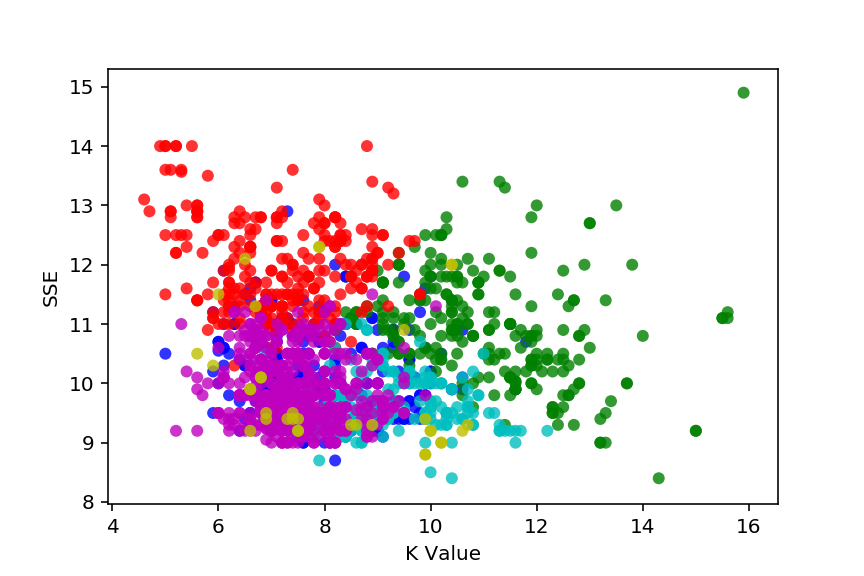

1 b Cluster 1
2 g Cluster 2
3 r Cluster 3
4 c Cluster 4
5 m Cluster 5
6 y Cluster 6


In [61]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
for data, color, group in zip(np.unique(clusters), colors, labels):
    print(data, color, group)
    x = wine_eda['fixed acidity'][np.where(clusters == data)[0]]
    y = wine_eda['alcohol'][np.where(clusters == data)[0]]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group) 
    ax.set_xlabel('K Value')
    ax.set_ylabel('SSE')

plt.show()
#plt.legend(loc=1)

### Pairwise scatter plot of all the features that were part of the analysis to observe the trends described above.

<IPython.core.display.Javascript object>


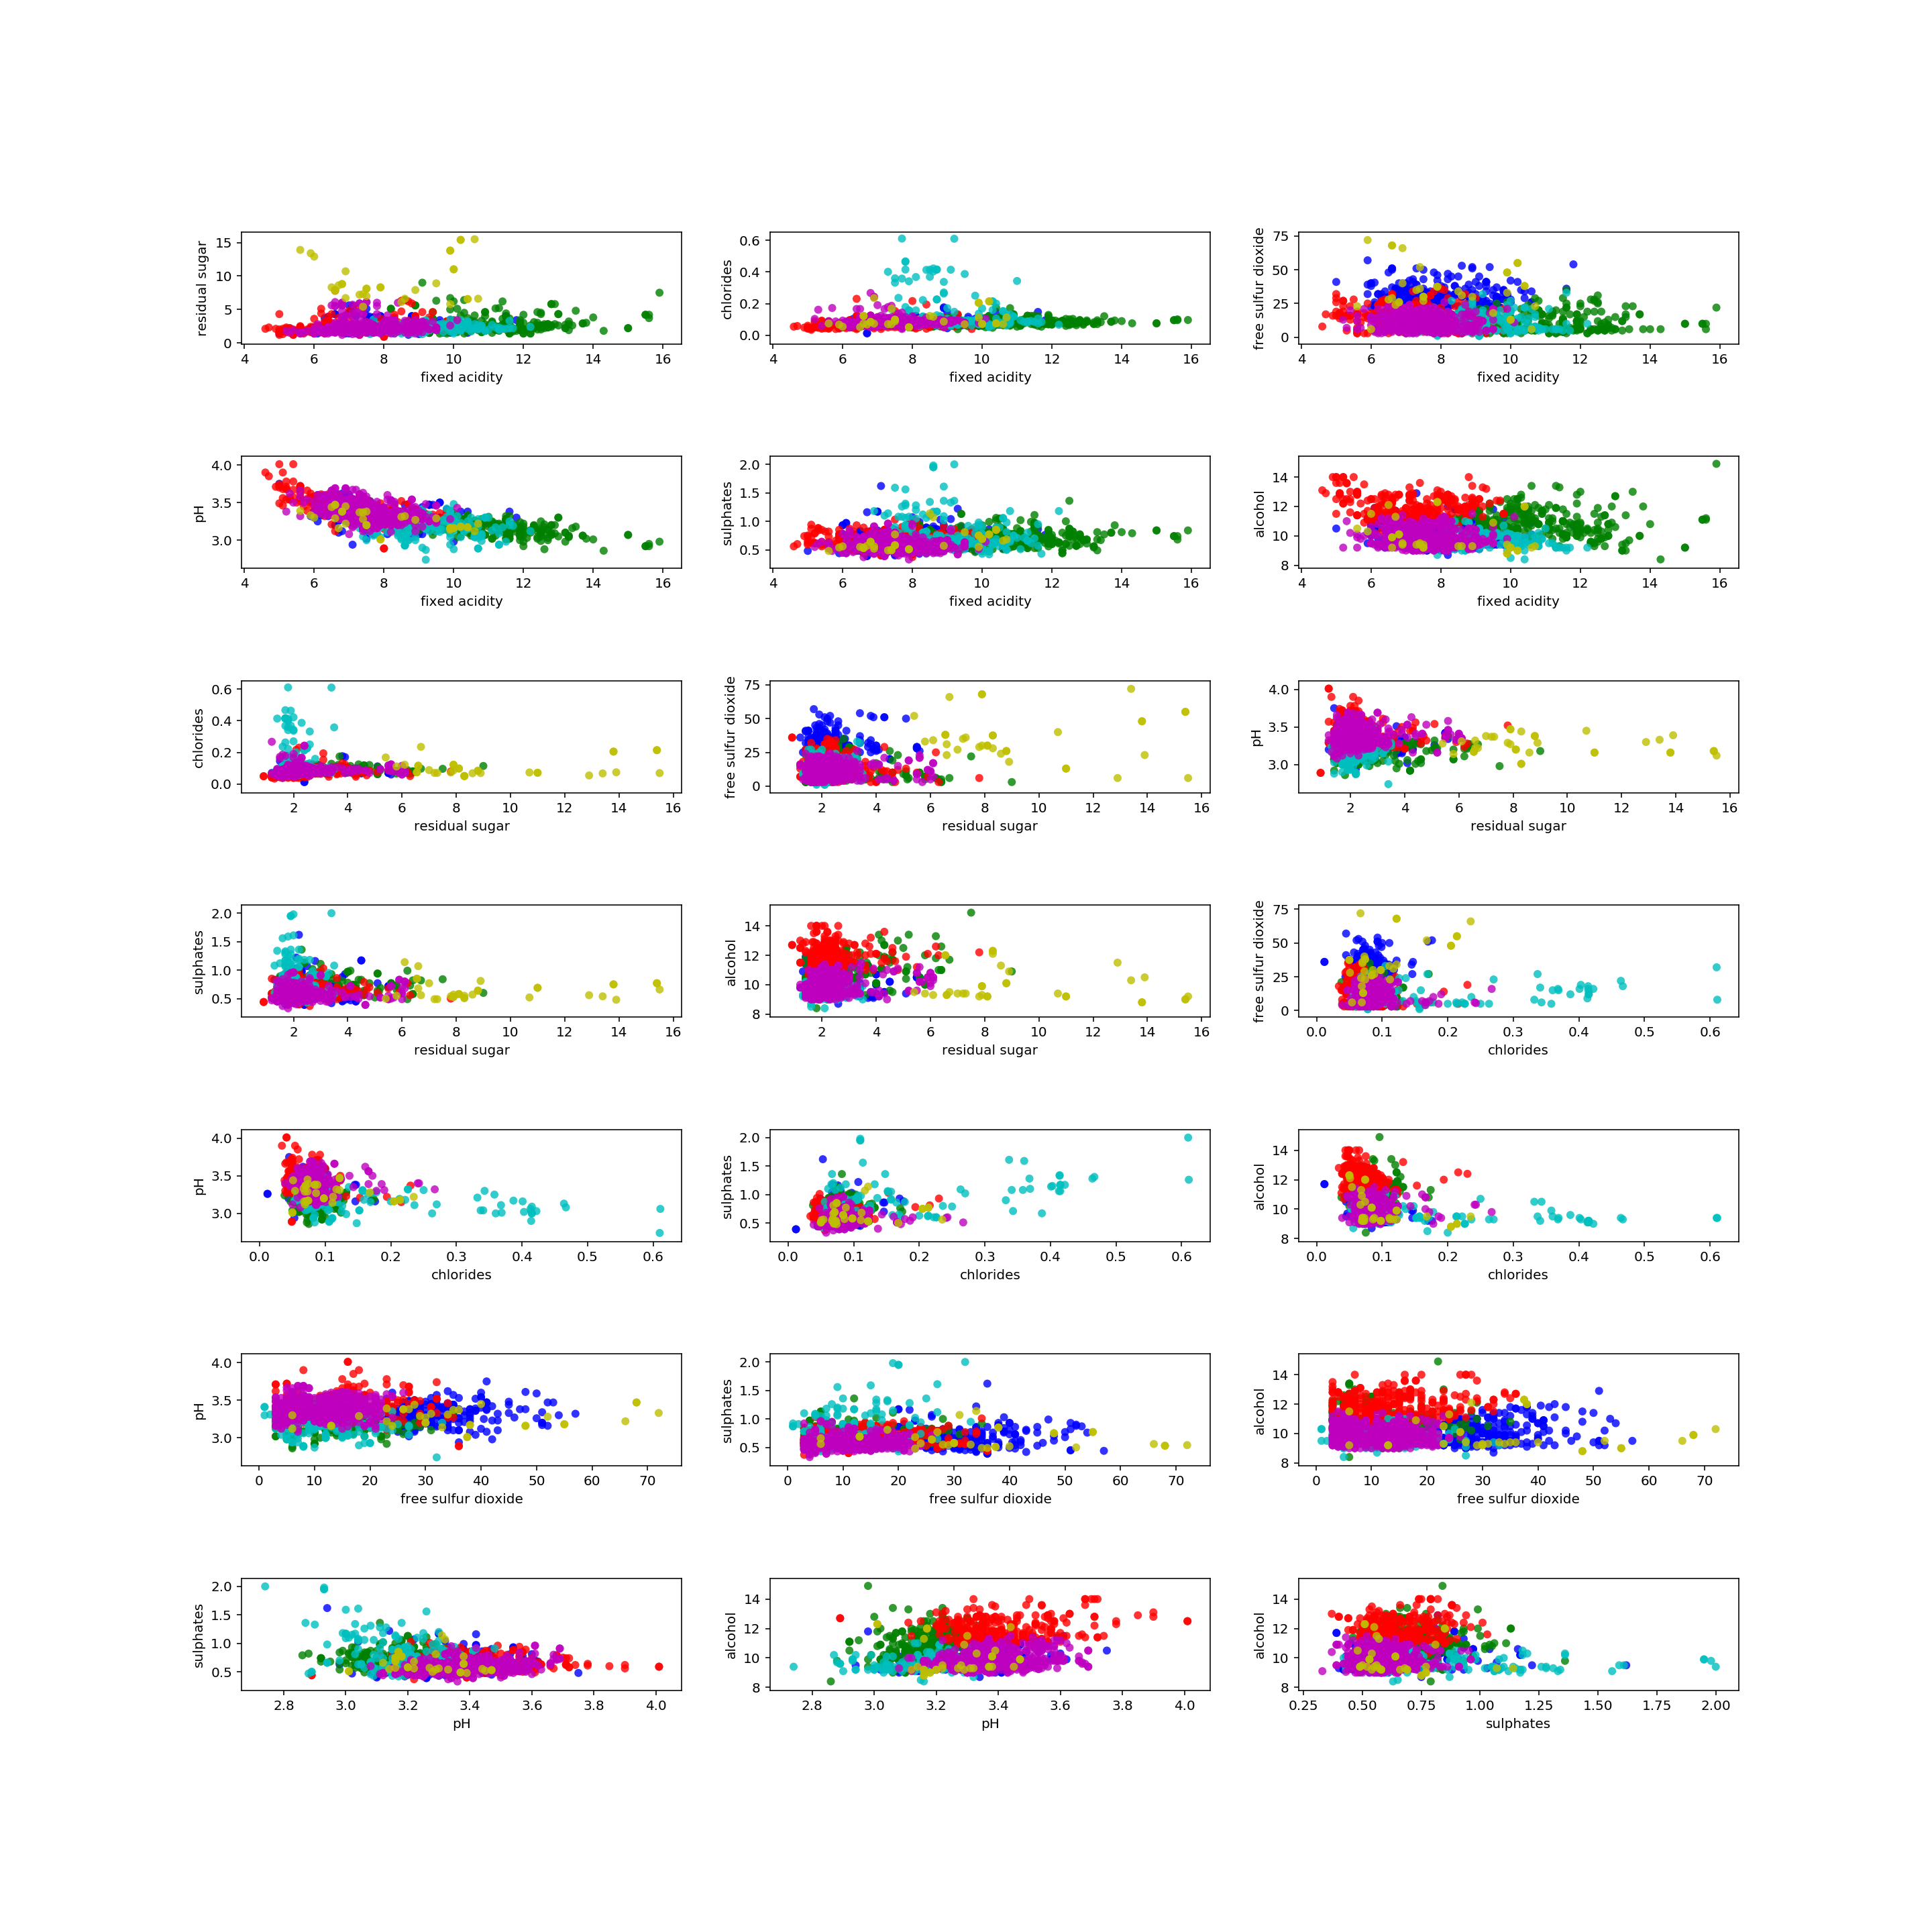

In [63]:
%matplotlib notebook

cols_of_interest = ['fixed acidity','residual sugar', 'chlorides','free sulfur dioxide', 'pH', 'sulphates', 'alcohol']
columns_list = []
for i in range(8):
    for j in range(i+1,len(cols_of_interest)):
        #print(i,j)
        columns_list.append((cols_of_interest[i], cols_of_interest[j]))

#f = plt.figure(figsize = (20, 30)).subplots_adjust(hspace=1)
fig, axes = plt.subplots(7, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=1)
#fig, ax = plt.subplots()
counter = -1
for i,j in columns_list:
    counter += 1
    for data, color, group in zip(np.unique(clusters), colors, labels):
            x = wine_eda[i][np.where(clusters == data)[0]]
            y = wine_eda[j][np.where(clusters == data)[0]]
            axes[int(counter/3),int(counter%3)].scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)
            axes[int(counter/3),int(counter%3)].set_xlabel(i)
            axes[int(counter/3),int(counter%3)].set_ylabel(j)
            #ax.plot()


        
plt.show()


## 4. Off the Shelf Algo

In [93]:

KMS = KMeansPack(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Two)
print(KMS)
SSE, SSB, SSE_cluster = calculateMeasures(Two, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
SSB : 64.296604
SSE : 111.888498
Cluster-wise SSE:
Cluster 1: 37.040000
Cluster 2: 32.320000
Cluster 3: 42.520000
Cluster 4: 0.000000


0 b
1 g
2 r


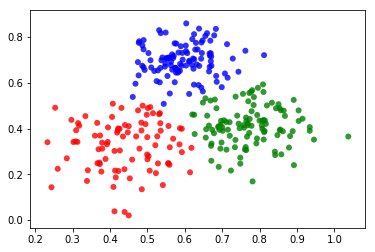

### Cluster graph

True Clusters,1,2,3,4
Assigned Cluster,,,,
1,89,2,4,0
2,0,0,3,104
3,0,98,2,8
4,0,0,88,2


In [94]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(KMS.labels_), colors, labels):
    print(data, color)
    x = Two[np.where(KMS.labels_ == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.show()

new_clusters = []
for i in KMS.labels_:
    if i == 3:
        new_clusters.append(1)
    elif i == 1:
        new_clusters.append(2)
    elif i == 0:
        new_clusters.append(3)
    elif i == 2:
        new_clusters.append(4)

printmd('### Cluster graph') 
display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


In [86]:
printmd('### Comparison across datasets') 

print('\nWine_Base')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

KMS

### Comparison across datasets


Wine_Base
SSB : 17671.378811
SSE : 24204.365985

Wine_Norm
SSB : 588.185036
SSE : 782.557858

Wine_Softmax
SSB : 973.046414
SSE : 1754.173980


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Agglomerative Clustering algorithm

This algorithm recursively merges the pair of clusters that minimally increases a given linkage distance. It starts with the points as individual clusters and at each step and merge the closest pair of clusters until only k clusters remain.

In [95]:
printmd('### Comparison across datasets') 

k = 6
print('\nWine_Base')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, updateCentroids(Wine_Norm, KMS.labels_, np.zeros((k,Wine_Norm.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, updateCentroids(Wine_Softmax, KMS.labels_, np.zeros((k,Wine_Softmax.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

KMS

### Comparison across datasets


Wine_Base
SSB : 9996.298281
SSE : 3894.626869

Wine_Norm
SSB : 295.051116
SSE : 321.810498

Wine_Softmax
SSB : 475.223781
SSE : 87.884104


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=6,
            pooling_func=<function mean at 0x10969fd90>)

### MiniBatchKMeans

The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

In [96]:


printmd('### Comparison across datasets') 
print('\nWine_Base')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

KMS

### Comparison across datasets


Wine_Base
SSB : 14037.119761
SSE : 24807.959074

Wine_Norm
SSB : 376.041500
SSE : 600.145141

Wine_Softmax
SSB : 1152.431284
SSE : 1769.502306


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=6,
        n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0001,
        verbose=0)

In [97]:

# print('\nWine_Base')
# KMS = Birch(n_clusters=6).fit(Wine_Base)
# SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
# print('SSB : %f' % (SSB))
# print('SSE : %f' % (SSE))

# print('\nWine_Norm')
# KMS = Birch(n_clusters=6).fit(Wine_Norm)
# SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
# print('SSB : %f' % (SSB))
# print('SSE : %f' % (SSE))

# print('\nWine_Softmax')
# KMS = Birch(n_clusters=6).fit(Wine_Softmax)
# SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
# print('SSB : %f' % (SSB))
# print('SSE : %f' % (SSE))

# KMS